# Capstone Time Series Modelling 


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter 
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller, acf, pacf
import warnings
warnings.filterwarnings("ignore")

In [3]:
# load dataset
df = pd.read_excel('water_quality_dataset.xlsx')
df["Main soil type region"] = df["Main soil type region"].replace("", pd.NA).fillna(method="ffill")



In [10]:
df

,Year,Component,Water type,Main soil type region,Company type,Season,Number of companies,Gem,Std,P10,P25,P50,P75,P90,Unit,DG,Perc dg
0,2022,Nitrate (NO3),leaching water,clay,arable farming,winter,30,37.0,24,11,21,30,45,73,mg/l,0.13,0
1,2022,Nitrate (NO3),leaching water,clay,dairy cattle,winter,58,19.0,28,0.67,3.8,7.4,21,48,mg/l,0.13,5.2
2,2022,Nitrate (NO3),leaching water,clay,animal farm,winter,13,20.0,26,"1,1",5.4,7.8,20,72,mg/l,0.13,0
3,2022,Nitrate (NO3),leaching water,clay,all,winter,101,27.0,27,2.8,6.5,19,42,71,mg/l,0.13,3
4,2022,Nitrate (NO3),leaching water,loess,arable farming,winter,19,99.0,65,38,58,85,115,165,mg/l,0.13,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
608,1993,Nitrate (NO3),leaching water,sand,dairy cattle,summer,65,189.0,78,107,134,182,255,288,mg/l,0.13,0
609,1993,Nitrate (NO3),leaching water,sand,all,summer,85,180.0,77,101,121,172,233,288,mg/l,0.13,0
610,1992,Nitrate (NO3),leaching water,sand,arable farming,summer,18,134.0,55,78,95,125,175,219,mg/l,0.13,0
611,1992,Nitrate (NO3),leaching water,sand,dairy cattle,summer,67,193.0,87,92,139,179,264,310,mg/l,0.13,0


In [4]:
season_month_map = {'winter': 1, 'spring': 4, 'summer': 7, 'fall': 10}
df['Season_Month'] = df['Season'].map(season_month_map)

# Create a 'Date' column using Year and Season_Month
df['Date'] = pd.to_datetime(df['Year'].astype(str) + '-' + df['Season_Month'].astype(str) + '-01')

columns_drop = ['Year', 'Season', 'Season_Month']

df = df.drop(columns=columns_drop)
df = df.sort_values('Date').reset_index(drop=True)

display(df)

,Component,Water type,Main soil type region,Company type,Number of companies,Gem,Std,P10,P25,P50,P75,P90,Unit,DG,Perc dg,Date
0,Nitrate (NO3),leaching water,sand,all,92,188.00,88,84,118,176,270,307,mg/l,0.13,0,1992-07-01
1,Nitrate (NO3),leaching water,sand,dairy cattle,67,193.00,87,92,139,179,264,310,mg/l,0.13,0,1992-07-01
2,Nitrate (NO3),leaching water,sand,arable farming,18,134.00,55,78,95,125,175,219,mg/l,0.13,0,1992-07-01
3,Nitrate (NO3),leaching water,sand,arable farming,15,143.00,61,82,107,124,170,212,mg/l,0.13,0,1993-07-01
4,Nitrate (NO3),leaching water,sand,all,85,180.00,77,101,121,172,233,288,mg/l,0.13,0,1993-07-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
608,Nitrate (NO3),ditch water,clay,arable farming,29,2.30,4.5,<dg,<dg,0.6,1.8,6.3,mg/l,0.13,28,2022-07-01
609,Nitrate (NO3),ditch water,clay,dairy cattle,52,0.84,2.9,<dg,<dg,<dg,0.27,"1,3",mg/l,0.13,65,2022-07-01
610,Nitrate (NO3),ditch water,clay,all,93,1.50,3.6,<dg,<dg,0.21,"1,3","3,4",mg/l,0.13,52,2022-07-01
611,Nitrate (NO3),leaching water,sand,arable farming,36,89.00,57,22,53,85,101,167,mg/l,0.13,0,2022-07-01


In [5]:
df_leaching =df[df['Water type'] == 'leaching water']
display(df_leaching.head())

,Component,Water type,Main soil type region,Company type,Number of companies,Gem,Std,P10,P25,P50,P75,P90,Unit,DG,Perc dg,Date
0,Nitrate (NO3),leaching water,sand,all,92,188.0,88,84,118,176,270,307,mg/l,0.13,0,1992-07-01
1,Nitrate (NO3),leaching water,sand,dairy cattle,67,193.0,87,92,139,179,264,310,mg/l,0.13,0,1992-07-01
2,Nitrate (NO3),leaching water,sand,arable farming,18,134.0,55,78,95,125,175,219,mg/l,0.13,0,1992-07-01
3,Nitrate (NO3),leaching water,sand,arable farming,15,143.0,61,82,107,124,170,212,mg/l,0.13,0,1993-07-01
4,Nitrate (NO3),leaching water,sand,all,85,180.0,77,101,121,172,233,288,mg/l,0.13,0,1993-07-01


In [6]:
df_sand = df_leaching[(df_leaching['Main soil type region'] == 'sand') & (df_leaching['Company type'] == 'all')]
display(df_sand.head())
df_clay = df_leaching[df_leaching['Main soil type region'] == 'clay']

df_loess = df_leaching[df_leaching['Main soil type region'] == 'loess']
df_peat = df_leaching[df_leaching['Main soil type region'] == 'peat']


,Component,Water type,Main soil type region,Company type,Number of companies,Gem,Std,P10,P25,P50,P75,P90,Unit,DG,Perc dg,Date
0,Nitrate (NO3),leaching water,sand,all,92,188.0,88,84,118,176,270,307,mg/l,0.13,0,1992-07-01
4,Nitrate (NO3),leaching water,sand,all,85,180.0,77,101,121,172,233,288,mg/l,0.13,0,1993-07-01
6,Nitrate (NO3),leaching water,sand,all,35,114.0,65,36,62,112,158,228,mg/l,0.13,0,1994-07-01
8,Nitrate (NO3),leaching water,sand,all,84,88.0,47,36,51,81,117,144,mg/l,0.13,0,1995-07-01
15,Nitrate (NO3),leaching water,sand,all,27,148.0,95,56,71,119,228,284,mg/l,0.13,0,1997-07-01


In [17]:
df_sand.to_csv('sand.csv', index=False)  

In [18]:
display(df_sand)

,Component,Water type,Main soil type region,Company type,Number of companies,Gem,Std,P10,P25,P50,P75,P90,Unit,DG,Perc dg,Date,Gem_diff
0,Nitrate (NO3),leaching water,sand,all,92,188.0,88,84,118,176,270,307,mg/l,0.13,0,1992-07-01,NaN
4,Nitrate (NO3),leaching water,sand,all,85,180.0,77,101,121,172,233,288,mg/l,0.13,0,1993-07-01,-8.0
6,Nitrate (NO3),leaching water,sand,all,35,114.0,65,36,62,112,158,228,mg/l,0.13,0,1994-07-01,-66.0
8,Nitrate (NO3),leaching water,sand,all,84,88.0,47,36,51,81,117,144,mg/l,0.13,0,1995-07-01,-26.0
15,Nitrate (NO3),leaching water,sand,all,27,148.0,95,56,71,119,228,284,mg/l,0.13,0,1997-07-01,60.0
22,Nitrate (NO3),leaching water,sand,all,39,140.0,82,65,81,123,192,286,mg/l,0.13,0,1998-07-01,-8.0
31,Nitrate (NO3),leaching water,sand,all,41,66.0,60,13,39,55,65,145,mg/l,0.13,0,1999-07-01,-74.0
38,Nitrate (NO3),leaching water,sand,all,42,91.0,54,38,52,77,111,175,mg/l,0.13,0,2000-07-01,25.0
43,Nitrate (NO3),leaching water,sand,all,41,85.0,64,12,39,78,119,143,mg/l,0.13,0,2001-07-01,-6.0
54,Nitrate (NO3),leaching water,sand,all,53,57.0,41,12,28,48,87,113,mg/l,0.13,0,2002-07-01,-28.0


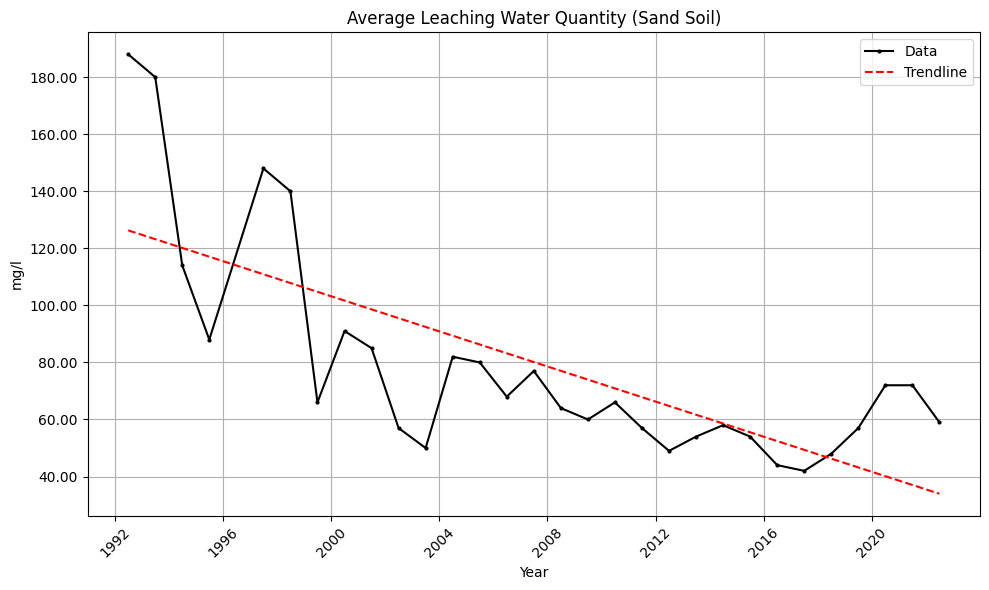

In [7]:
import numpy as np
from scipy.stats import linregress
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Perform linear regression on the 'Gem' values
slope, intercept, r_value, p_value, std_err = linregress(df_sand['Date'].map(lambda x: x.toordinal()), df_sand['Gem'])

# Generate the trendline (y = slope * x + intercept)
trendline = slope * df_sand['Date'].map(lambda x: x.toordinal()) + intercept

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(df_sand['Date'], df_sand['Gem'], marker='o', linestyle='-', color='black', markersize=2, label='Data')
plt.plot(df_sand['Date'], trendline, linestyle='--', color='red', label='Trendline')

# Title and labels
plt.title('Average Leaching Water Quantity (Sand Soil)')
plt.xlabel('Year')
plt.ylabel('mg/l')
plt.grid(True)

# Manually format y-axis labels to avoid scientific notation
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.2f}'.format(x)))

# Rotate x-axis labels
plt.xticks(rotation=45)

# Add a legend to differentiate between data and trendline
plt.legend()

# Tight layout
plt.tight_layout()

# Show the plot
plt.show()


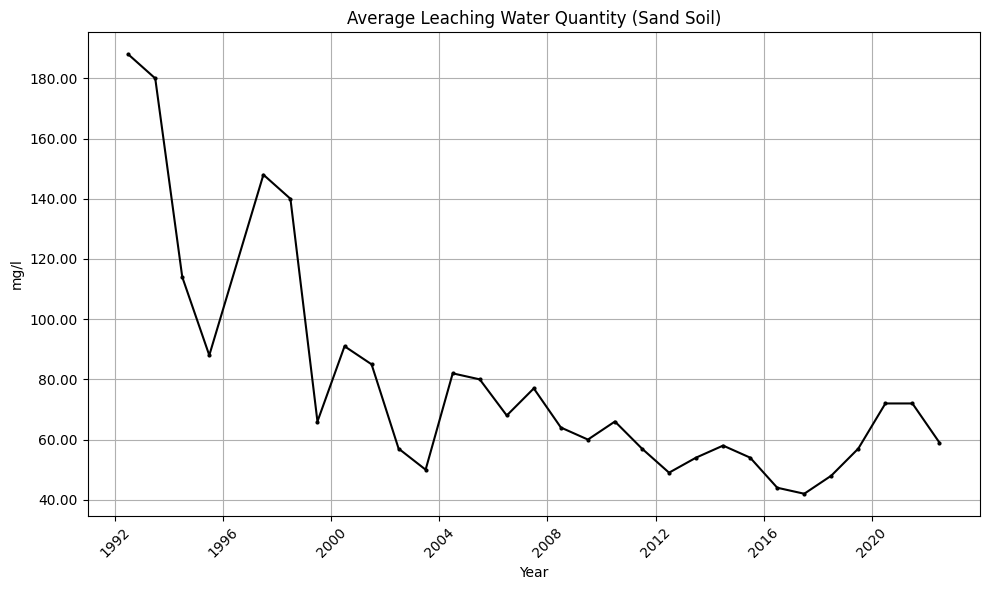

In [44]:
# Plot the time series data
plt.figure(figsize=(10, 6))
plt.plot(df_sand.index,  df_sand['Gem'], marker='o', linestyle='-', color='black',markersize = '2')
plt.title('Average Leaching Water Quantity (Sand Soil)')
plt.xlabel('Year')
plt.ylabel('mg/l')
plt.grid(True)

# Manually format y-axis labels to avoid scientific notation
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.2f}'.format(x)))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [20]:
df_sand['Date'] = pd.to_datetime(df_sand['Date'])  # Convert to datetime

In [33]:
df_sand=df_sand.set_index('Date')  # Set as index

In [ ]:
import pandas as pd

# Load your DataFrame (assuming it's already in a variable called df_sand)
df_sand['Date'] = pd.to_datetime(df_sand['Date'])  # Convert to datetime
df_sand.set_index('Date', inplace=True)  # Set as index
# df_sand.sort_index(inplace=True)  # Ensure the index is sorted

# Optional: Set frequency if the data is evenly spaced (e.g., yearly)
df_sand = df_sand.asfreq('Y')  # Adjust if the data has another frequency like 'M' for months

df_sand.head()
print(df_sand.index.freq)  # Should print 'A-DEC' (Year-end frequency) or None if irregular


<YearEnd: month=12>


In [34]:
df_sand.head()

,Component,Water type,Main soil type region,Company type,Number of companies,Gem,Std,P10,P25,P50,P75,P90,Unit,DG,Perc dg
Date,,,,,,,,,,,,,,,
1992-07-01,Nitrate (NO3),leaching water,sand,all,92,188.0,88,84,118,176,270,307,mg/l,0.13,0
1993-07-01,Nitrate (NO3),leaching water,sand,all,85,180.0,77,101,121,172,233,288,mg/l,0.13,0
1994-07-01,Nitrate (NO3),leaching water,sand,all,35,114.0,65,36,62,112,158,228,mg/l,0.13,0
1995-07-01,Nitrate (NO3),leaching water,sand,all,84,88.0,47,36,51,81,117,144,mg/l,0.13,0
1997-07-01,Nitrate (NO3),leaching water,sand,all,27,148.0,95,56,71,119,228,284,mg/l,0.13,0


In [35]:

display(df_sand)

decomposition = sm.tsa.seasonal_decompose(df_sand['Gem'], model='additive', extrapolate_trend=12)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

fig = decomposition.plot()
fig.set_size_inches(14, 7)
plt.show()

,Component,Water type,Main soil type region,Company type,Number of companies,Gem,Std,P10,P25,P50,P75,P90,Unit,DG,Perc dg
Date,,,,,,,,,,,,,,,
1992-07-01,Nitrate (NO3),leaching water,sand,all,92,188.0,88,84,118,176,270,307,mg/l,0.13,0
1993-07-01,Nitrate (NO3),leaching water,sand,all,85,180.0,77,101,121,172,233,288,mg/l,0.13,0
1994-07-01,Nitrate (NO3),leaching water,sand,all,35,114.0,65,36,62,112,158,228,mg/l,0.13,0
1995-07-01,Nitrate (NO3),leaching water,sand,all,84,88.0,47,36,51,81,117,144,mg/l,0.13,0
1997-07-01,Nitrate (NO3),leaching water,sand,all,27,148.0,95,56,71,119,228,284,mg/l,0.13,0
1998-07-01,Nitrate (NO3),leaching water,sand,all,39,140.0,82,65,81,123,192,286,mg/l,0.13,0
1999-07-01,Nitrate (NO3),leaching water,sand,all,41,66.0,60,13,39,55,65,145,mg/l,0.13,0
2000-07-01,Nitrate (NO3),leaching water,sand,all,42,91.0,54,38,52,77,111,175,mg/l,0.13,0
2001-07-01,Nitrate (NO3),leaching water,sand,all,41,85.0,64,12,39,78,119,143,mg/l,0.13,0


ValueError: You must specify a period or x must be a pandas object with a PeriodIndex or a DatetimeIndex with a freq not set to None

In [ ]:
decomposition = sm.tsa.seasonal_decompose(df_sand['Gem'], model='additive', extrapolate_trend=12)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

fig = decomposition.plot()
fig.set_size_inches(14, 7)
plt.show()

ValueError: You must specify a period or x must be a pandas object with a PeriodIndex or a DatetimeIndex with a freq not set to None

In [ ]:

df_sand = df_sand.asfreq('QS')
df_sand = df_sand.dropna()

In [27]:
print(df_sand.index)
print(df_sand.index.freq)


Int64Index([  0,   4,   6,   8,  15,  22,  31,  38,  43,  54,  66,  76,  93,
            115, 135, 161, 199, 231, 262, 290, 329, 362, 391, 422, 453, 484,
            518, 546, 570, 607],
           dtype='int64')


AttributeError: 'Int64Index' object has no attribute 'freq'

In [36]:
df_sand

,Component,Water type,Main soil type region,Company type,Number of companies,Gem,Std,P10,P25,P50,P75,P90,Unit,DG,Perc dg
Date,,,,,,,,,,,,,,,
1992-07-01,Nitrate (NO3),leaching water,sand,all,92,188.0,88,84,118,176,270,307,mg/l,0.13,0
1993-07-01,Nitrate (NO3),leaching water,sand,all,85,180.0,77,101,121,172,233,288,mg/l,0.13,0
1994-07-01,Nitrate (NO3),leaching water,sand,all,35,114.0,65,36,62,112,158,228,mg/l,0.13,0
1995-07-01,Nitrate (NO3),leaching water,sand,all,84,88.0,47,36,51,81,117,144,mg/l,0.13,0
1997-07-01,Nitrate (NO3),leaching water,sand,all,27,148.0,95,56,71,119,228,284,mg/l,0.13,0
1998-07-01,Nitrate (NO3),leaching water,sand,all,39,140.0,82,65,81,123,192,286,mg/l,0.13,0
1999-07-01,Nitrate (NO3),leaching water,sand,all,41,66.0,60,13,39,55,65,145,mg/l,0.13,0
2000-07-01,Nitrate (NO3),leaching water,sand,all,42,91.0,54,38,52,77,111,175,mg/l,0.13,0
2001-07-01,Nitrate (NO3),leaching water,sand,all,41,85.0,64,12,39,78,119,143,mg/l,0.13,0


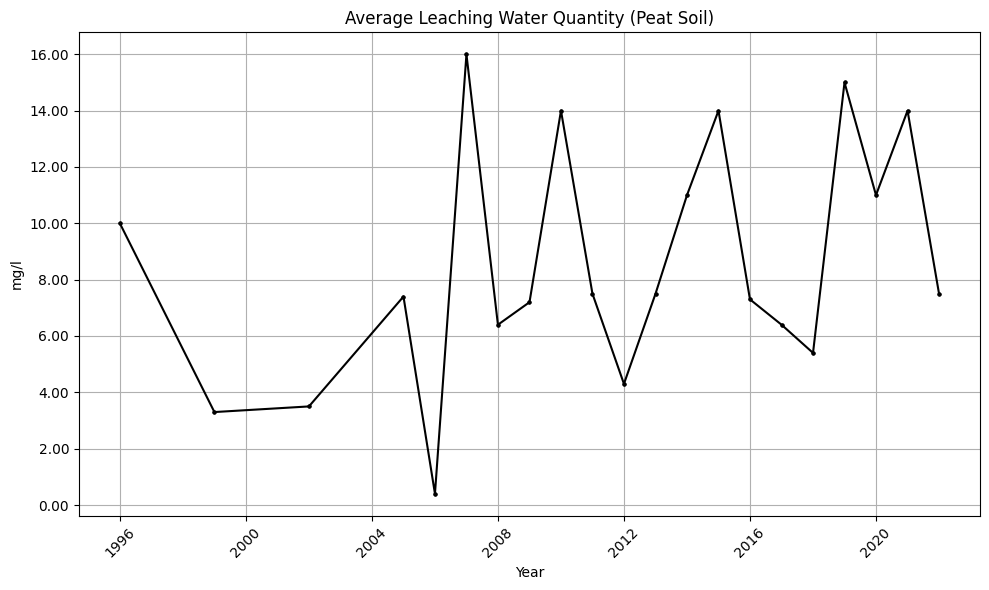

In [10]:
# Plot the time series data
plt.figure(figsize=(10, 6))
plt.plot(df_peat['Date'], df_peat['Gem'], marker='o', linestyle='-', color='black',markersize = '2')
plt.title('Average Leaching Water Quantity (Peat Soil)')
plt.xlabel('Year')
plt.ylabel('mg/l')
plt.grid(True)
# Manually format y-axis labels to avoid scientific notation
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.2f}'.format(x)))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

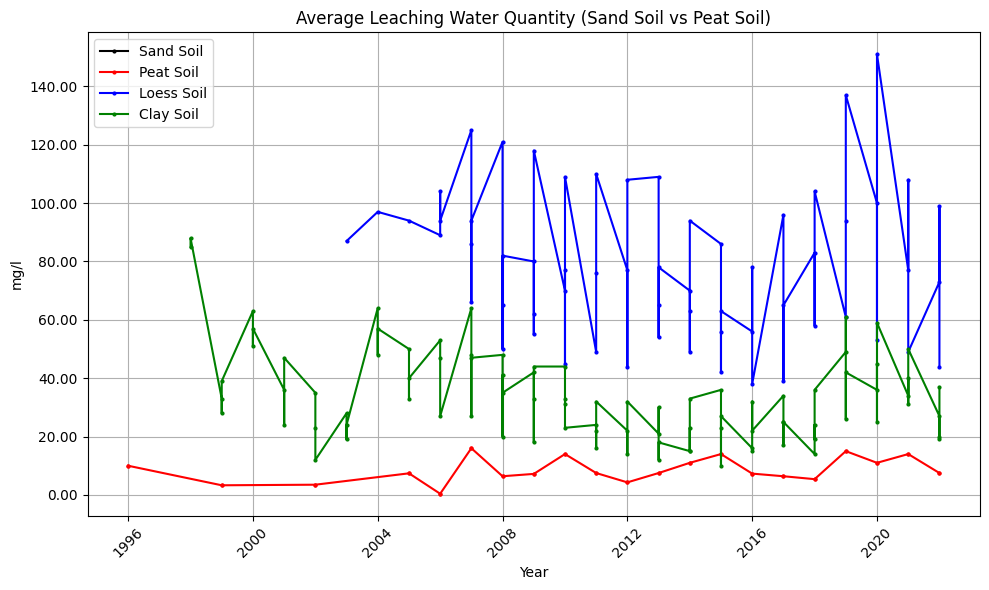

In [11]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Create a figure with a specific size
plt.figure(figsize=(10, 6))

# Plot the Sand Soil data
plt.plot(df_sand['Date'], df_sand['Gem'], marker='o', linestyle='-', color='black', markersize=2, label='Sand Soil')

# Plot the Peat Soil data
plt.plot(df_peat['Date'], df_peat['Gem'], marker='o', linestyle='-', color='red', markersize=2, label='Peat Soil')
plt.plot(df_loess['Date'], df_loess['Gem'], marker='o', linestyle='-', color='blue', markersize=2, label='Loess Soil')
plt.plot(df_clay['Date'], df_clay['Gem'], marker='o', linestyle='-', color='green', markersize=2, label='Clay Soil')

# Add title and labels
plt.title('Average Leaching Water Quantity (Sand Soil vs Peat Soil)')
plt.xlabel('Year')
plt.ylabel('mg/l')

# Add a legend
plt.legend()

# Add a grid for better visualization
plt.grid(True)

# Manually format y-axis labels to avoid scientific notation
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.2f}'.format(x)))

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Adjust layout to ensure everything fits well
plt.tight_layout()

# Show the plot
plt.show()


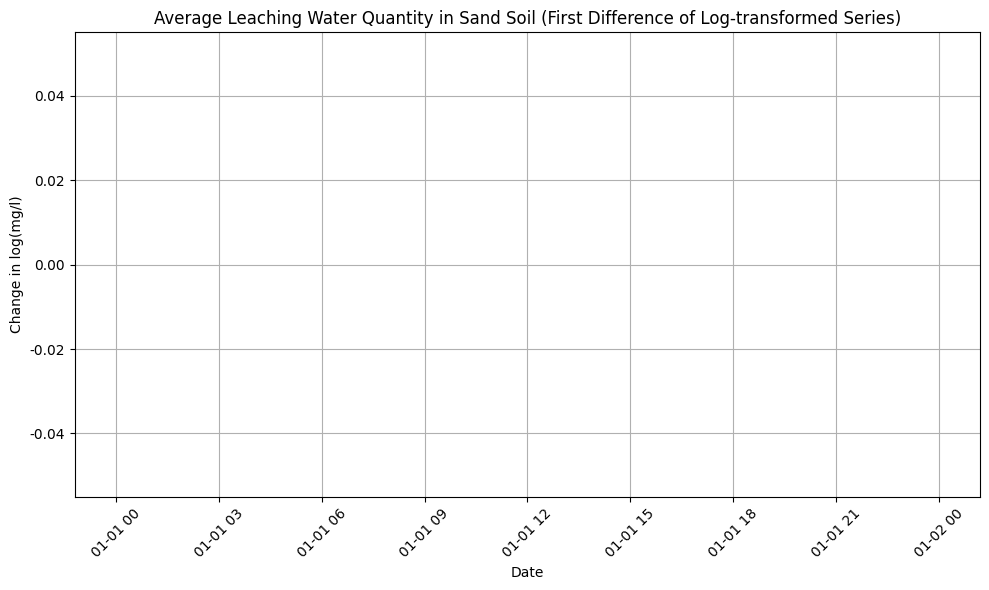

In [12]:
# Calculate the first difference 
df_sand['log_gem'] = np.log(df_sand['Gem'])
df_sand['log_gem_diff'] = df_sand['log_gem'].diff()

# Plotting the first difference of the log-transformed series
plt.figure(figsize=(10, 6))
plt.plot(df_sand['Date'], df_sand['log_gem_diff'], marker='o', linestyle='-', color='black', markersize=2,linewidth=0.5)
plt.title('Average Leaching Water Quantity in Sand Soil (First Difference of Log-transformed Series)')
plt.xlabel('Date')
plt.ylabel('Change in log(mg/l)')
plt.grid(True)
# Manually format y-axis labels to avoid scientific notation
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.2f}'.format(x)))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

ValueError: negative dimensions are not allowed

<Figure size 1200x600 with 0 Axes>

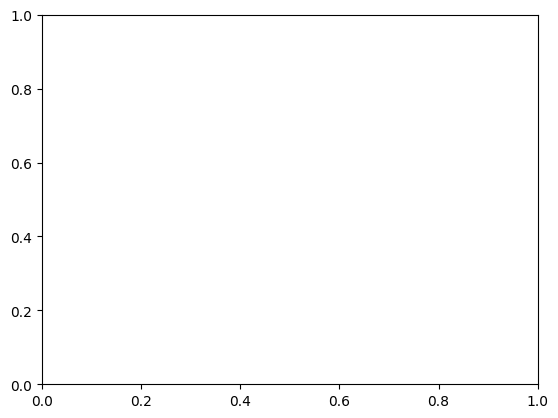

In [14]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plotting the Autocorrelation Function (ACF)
plt.figure(figsize=(12, 6))
plot_acf(df_sand['log_gem'].dropna(), lags=30, alpha=0.05, title='Autocorrelation Function (ACF) for Log-transformed Series')
plt.tight_layout()

# Plotting the Partial Autocorrelation Function (PACF)
plt.figure(figsize=(12, 6))
plot_pacf(df_sand['log_gem'].dropna(), lags=30, alpha=0.05, title='Partial Autocorrelation Function (PACF) for Log-transformed Series')
plt.tight_layout()

plt.show()


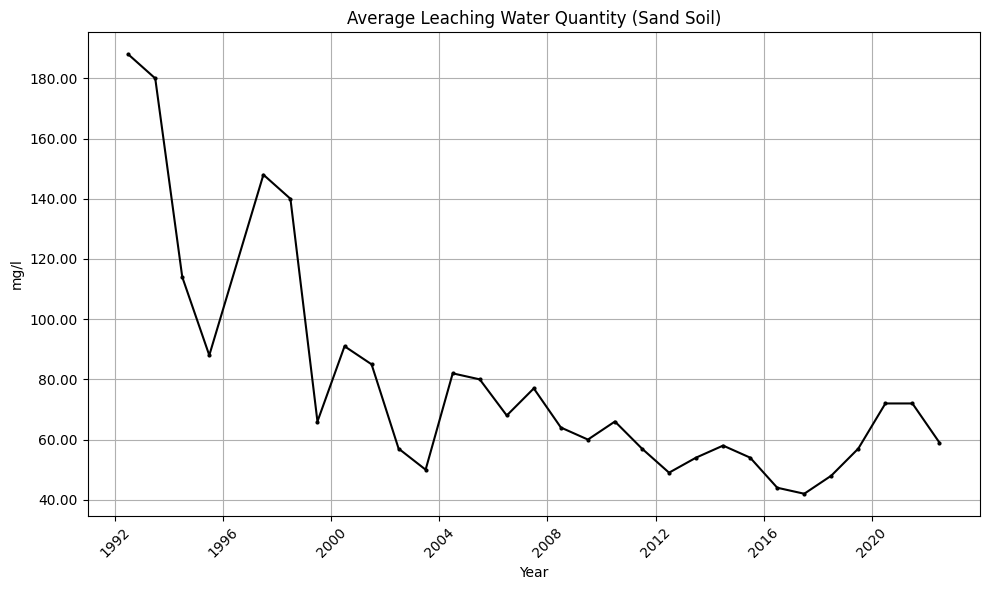

In [45]:
# Plot the time series data
plt.figure(figsize=(10, 6))
plt.plot(df_sand.index,  df_sand['Gem'], marker='o', linestyle='-', color='black',markersize = '2')
plt.title('Average Leaching Water Quantity (Sand Soil)')
plt.xlabel('Year')
plt.ylabel('mg/l')
plt.grid(True)

# Manually format y-axis labels to avoid scientific notation
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.2f}'.format(x)))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [49]:
len(df_sand['Gem'])

30

In [8]:
from statsmodels.tsa.stattools import adfuller

# Applying the Augmented Dickey-Fuller test on the first-differenced log-transformed series
# Note: We drop the first NaN value that results from differencing
adf_result = adfuller(df_sand['Gem'].dropna())

adf_output = pd.Series(adf_result[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key, value in adf_result[4].items():
    adf_output[f'Critical Value ({key})'] = value

adf_output

Test Statistic                 -4.735479
p-value                         0.000072
#Lags Used                      5.000000
Number of Observations Used    24.000000
Critical Value (1%)            -3.737709
Critical Value (5%)            -2.992216
Critical Value (10%)           -2.635747
dtype: float64

<Figure size 1200x600 with 0 Axes>

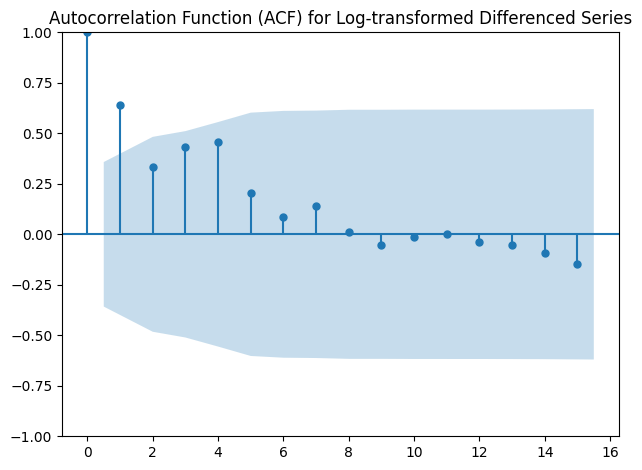

<Figure size 1200x600 with 0 Axes>

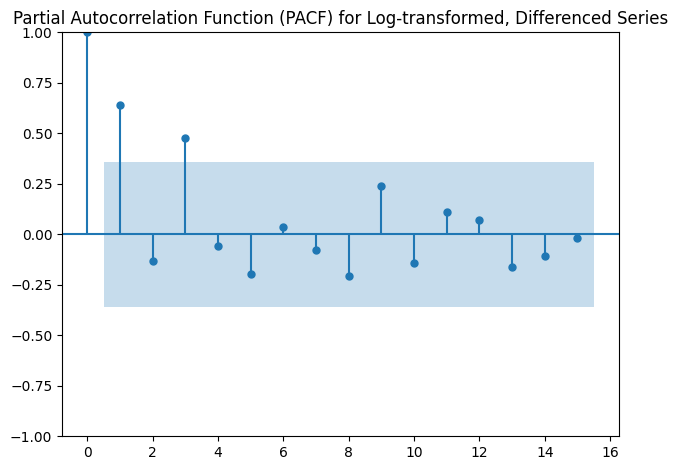

In [53]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plotting the Autocorrelation Function (ACF)
plt.figure(figsize=(12, 6))
plot_acf(df_sand['Gem'].dropna(), alpha=0.05, title='Autocorrelation Function (ACF) for Log-transformed Differenced Series')
plt.tight_layout()

# Plotting the Partial Autocorrelation Function (PACF)
plt.figure(figsize=(12, 6))
plot_pacf(df_sand['Gem'].dropna(), alpha=0.05, title='Partial Autocorrelation Function (PACF) for Log-transformed, Differenced Series')
plt.tight_layout()

plt.show()

In [ ]:
from statsmodels.tsa.stattools import adfuller

# Applying the Augmented Dickey-Fuller test on the first-differenced log-transformed series
# Note: We drop the first NaN value that results from differencing
adf_result = adfuller(df['Close'].dropna())

adf_output = pd.Series(adf_result[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key, value in adf_result[4].items():
    adf_output[f'Critical Value ({key})'] = value

adf_output

In [38]:
df_sand

,Component,Water type,Main soil type region,Company type,Number of companies,Gem,Std,P10,P25,P50,P75,P90,Unit,DG,Perc dg
Date,,,,,,,,,,,,,,,
1992-07-01,Nitrate (NO3),leaching water,sand,all,92,188.0,88,84,118,176,270,307,mg/l,0.13,0
1993-07-01,Nitrate (NO3),leaching water,sand,all,85,180.0,77,101,121,172,233,288,mg/l,0.13,0
1994-07-01,Nitrate (NO3),leaching water,sand,all,35,114.0,65,36,62,112,158,228,mg/l,0.13,0
1995-07-01,Nitrate (NO3),leaching water,sand,all,84,88.0,47,36,51,81,117,144,mg/l,0.13,0
1997-07-01,Nitrate (NO3),leaching water,sand,all,27,148.0,95,56,71,119,228,284,mg/l,0.13,0
1998-07-01,Nitrate (NO3),leaching water,sand,all,39,140.0,82,65,81,123,192,286,mg/l,0.13,0
1999-07-01,Nitrate (NO3),leaching water,sand,all,41,66.0,60,13,39,55,65,145,mg/l,0.13,0
2000-07-01,Nitrate (NO3),leaching water,sand,all,42,91.0,54,38,52,77,111,175,mg/l,0.13,0
2001-07-01,Nitrate (NO3),leaching water,sand,all,41,85.0,64,12,39,78,119,143,mg/l,0.13,0


In [9]:
df_sand['Gem_diff'] = df_sand['Gem'].diff().dropna()

adf_result = adfuller(df_sand['Gem_diff'].dropna())

adf_output = pd.Series(adf_result[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key, value in adf_result[4].items():
    adf_output[f'Critical Value ({key})'] = value

adf_output

Test Statistic                 -1.541234
p-value                         0.513024
#Lags Used                      4.000000
Number of Observations Used    24.000000
Critical Value (1%)            -3.737709
Critical Value (5%)            -2.992216
Critical Value (10%)           -2.635747
dtype: float64

In [40]:
df_sand['log_gem'] = np.log(df_sand['Gem'])
df_sand['log_gem_diff'] = df_sand['log_gem'].diff()

adf_result = adfuller(df_sand['log_gem_diff'].dropna())

adf_output = pd.Series(adf_result[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key, value in adf_result[4].items():
    adf_output[f'Critical Value ({key})'] = value

adf_output


Test Statistic                 -2.278859
p-value                         0.178877
#Lags Used                      4.000000
Number of Observations Used    24.000000
Critical Value (1%)            -3.737709
Critical Value (5%)            -2.992216
Critical Value (10%)           -2.635747
dtype: float64

In [1]:
from pmdarima import auto_arima
import pandas as pd

# Note: We drop the first NaN value that results from differencing
series = df_sand['Gem'].dropna()
series.index = pd.to_datetime(series.index) # Assuming 'series.index' contains date strings


# Use auto_arima to find the optimal SARIMA model
auto_model = auto_arima(series,
                        start_p=0, start_q=0,
                        max_p=20, max_q=20,  # Maximum p and q
                        #m=4,  # Adjust this based on your seasonality (e.g., 12 for monthly data with annual seasonality)
                        #start_P=0, start_Q=0, 
                        #max_P=20, max_Q=20,
                        seasonal=False,  # Enable search for seasonal parameters
                        #D=1,  # Assuming one seasonal differencing. Adjust as needed.
                        test='adf',  # Use ADF test to find optimal 'd'
                        trace=True,
                        error_action='ignore',  
                        suppress_warnings=True, 
                        stepwise=False)

print(auto_model.summary())

NameError: name 'df_sand' is not defined

In [11]:
order = auto_model.order

# Extract the seasonal order (P, D, Q, m)
seasonal_order = auto_model.seasonal_order

print(f"Non-seasonal order: {order}")
print(f"Seasonal order: {seasonal_order}")

Non-seasonal order: (0, 2, 0)
Seasonal order: (0, 0, 0, 0)


In [12]:
from tqdm import trange
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [13]:
# Split the dataset into training and test sets
train_size = int(len(series) * 0.95)
series_train, series_test = series[:train_size], series[train_size:]

history = series_train.values.copy()
predictions = []
confidence_intervals = []

# Rolling forecast origin
for t in trange(len(series_test)):
    # Fit the SARIMA model on the history
    model = SARIMAX(history, order=order, seasonal_order=(1,1,1,4))
    model_fit = model.fit(disp=False)  # Suppress fitting messages
    
    # Forecast the next point and get the 95% confidence interval
    forecast_result = model_fit.get_forecast(steps=12)
    yhat = forecast_result.predicted_mean
    conf_int = forecast_result.conf_int(alpha=0.05)  # 95% confidence interval
    
    predictions.append(yhat[0])  # Access forecast result correctly
    confidence_intervals.append(conf_int[0])  # Store confidence interval for each forecast
    
    # Correctly add the actual observation from series_test to history for the next loop
    actual_obs = series_test.iloc[t]  # Use .iloc[t] to correctly access the observation
    history = np.append(history, actual_obs)

100%|██████████| 2/2 [00:00<00:00, 13.88it/s]


Test RMSE: 31.714550637630747


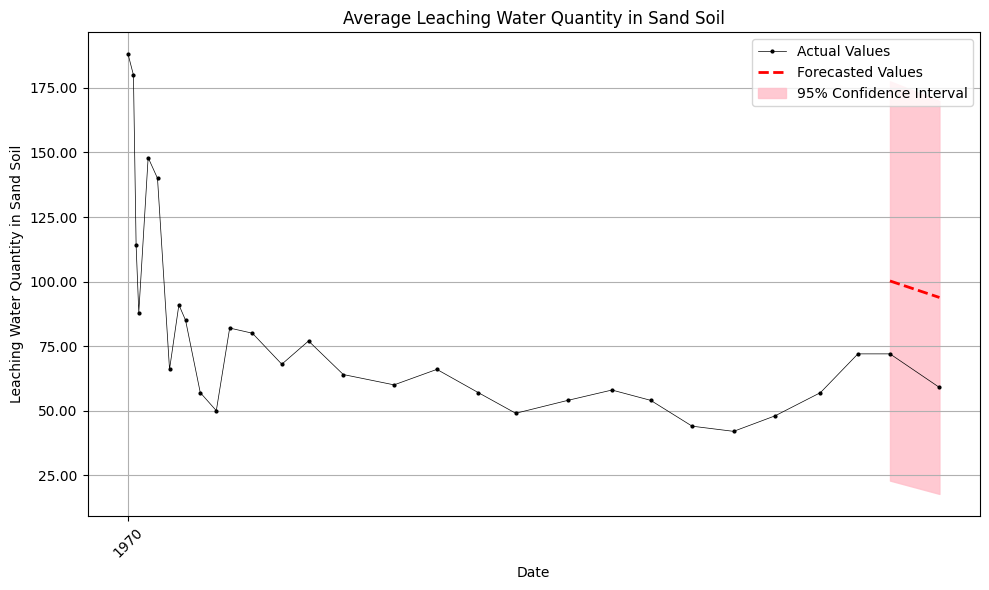

In [16]:
# Calculate RMSE
rmse = np.sqrt(np.mean((predictions - series_test)**2))
print(f'Test RMSE: {rmse}')

# Plotting the forecast along with the actual series and confidence intervals
plt.figure(figsize=(10, 6))
# Plotting the entire original series
plt.plot(series.index, series, marker='o', linestyle='-', color='black', markersize=2, linewidth=0.5, label='Actual Values')

# Plotting the forecasted values on the test set
plt.plot(series_test.index, predictions, label='Forecasted Values', color='red', linestyle='--', linewidth=2)

# Extracting lower and upper confidence bounds
lower_bounds = [ci[0] for ci in confidence_intervals]
upper_bounds = [ci[1] for ci in confidence_intervals]

# Plotting the confidence interval
plt.fill_between(series_test.index, lower_bounds, upper_bounds, color='pink', alpha=0.85, label='95% Confidence Interval')

plt.title('Average Leaching Water Quantity in Sand Soil')
plt.xlabel('Date')
plt.ylabel('Leaching Water Quantity in Sand Soil')
plt.grid(True)
# Manually format y-axis labels to avoid scientific notation
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.2f}'.format(x)))
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Number of periods to forecast (for example, 12 months into the future)
forecast_steps = 1200

# Extend the forecast horizon
extended_predictions = []
extended_confidence_intervals = []

# Use the last available data (from the end of the training set)
history = series.values[-train_size:].copy()

for t in range(forecast_steps):
    # Fit the SARIMA model on the current history
    model = SARIMAX(history, order=order, seasonal_order=(1,1,1,4))
    model_fit = model.fit(disp=False)  # Suppress fitting messages
    
    # Forecast the next point and get the 95% confidence interval
    forecast_result = model_fit.get_forecast(steps=1)
    yhat = forecast_result.predicted_mean
    conf_int = forecast_result.conf_int(alpha=0.05)  # 95% confidence interval
    
    extended_predictions.append(yhat[0])  # Store forecasted value
    extended_confidence_intervals.append((conf_int[0][0], conf_int[0][1]))

    # Update history with the new forecasted value
    history = np.append(history, yhat[0])

# Create DataFrame for the extended forecast and confidence intervals
forecast_index = pd.date_range(start=series.index[-1] + pd.Timedelta(days=1), periods=forecast_steps, freq='D')
extended_predictions_df = pd.DataFrame({
    'Prediction': extended_predictions,
    'Lower CI': [ci[0] for ci in extended_confidence_intervals],
    'Upper CI': [ci[1] for ci in extended_confidence_intervals]
}, index=forecast_index)

# Plotting the forecasted values along with confidence intervals
plt.figure(figsize=(10, 6))

# Plotting the entire original series
plt.plot(series.index, series, marker='o', linestyle='-', color='black', markersize=2, linewidth=0.5, label='Actual Values')

# Plotting the forecasted values
plt.plot(extended_predictions_df.index, extended_predictions_df['Prediction'], label='Forecasted Values', color='red', linestyle='--', linewidth=2)

# Extracting lower and upper confidence bounds
lower_bounds = extended_predictions_df['Lower CI']
upper_bounds = extended_predictions_df['Upper CI']

# Plotting the confidence interval
plt.fill_between(extended_predictions_df.index, lower_bounds, upper_bounds, color='pink', alpha=0.85, label='95% Confidence Interval')

plt.title('Extended Forecast with SARIMA')
plt.xlabel('Date')
plt.ylabel('Change in log(USD)')
plt.grid(True)

# Manually format y-axis labels to avoid scientific notation
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.2f}'.format(x)))

plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()
